# Imports

In [16]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn

import random
import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
import seaborn as sns

from collections import Counter

# Loading Data

In [2]:
data_raw = pd.read_csv('train.csv')
data_val = pd.read_csv('test.csv')

train_ids = data_raw['PassengerId']
test_ids = data_val['PassengerId']

data_c = data_raw.copy(deep = True)
data_all = [data_c, data_val]

print(data_c.info())
print(data_val.info())
data_c.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(data_c.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())
data_c.describe(include = 'all')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Olsvigen, Mr. Thor Anderson",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# Cleaning Data

### Names and Titles

In [4]:
#We check the different titles we have and group them into more general groups

titles = set()
for dataset in data_all:
    for name in dataset['Name']:
        titles.add(name.split(', ')[1].split('. ')[0])
print(titles)

{'Mr', 'Mrs', 'Dr', 'Lady', 'Jonkheer', 'Mme', 'Mlle', 'Don', 'Major', 'Capt', 'Miss', 'Master', 'Ms', 'Sir', 'Rev', 'the Countess', 'Col', 'Dona'}


In [5]:
title_groups = {
    'Col':'Officer',
    'Dona':'Royalty', 
    'Don':'Royalty',
    'Lady':'Royalty',
    'Mme':'Mrs',
    'Mr':'Mr',
    'Master':'Master',
    'Capt':'Officer',
    'Jonkheer':'Royalty',
    'Miss':'Miss',
    'Dr':'Officer',
    'Mlle':'Miss',
    'the Countess':'Royalty',
    'Mrs':'Mrs',
    'Major':'Officer',
    'Ms':'Mrs',
    'Rev':'Officer',
    'Sir':'Royalty'
}

for dataset in data_all:
    dataset['Title'] = dataset['Name'].map(lambda x : x.split(', ')[1].split('. ')[0]).map(title_groups)
    
#Doing a one-hot encoding of the Titles may help us depending on model. The Names column will much likely be droped in the future.

### Age

In [6]:
#We have 177 nulls in Age. Lets see the average Age per sex, title and class in the train dataset:
age_medians = data_c.groupby(['Sex','Pclass','Title']).median()[['Age','Survived']].reset_index()
age_medians
#We can also see the difference in survival chances with these variables

,Sex,Pclass,Title,Age,Survived
0,female,1,Miss,30.0,1.0
1,female,1,Mrs,40.0,1.0
2,female,1,Officer,49.0,1.0
3,female,1,Royalty,40.5,1.0
4,female,2,Miss,24.0,1.0
5,female,2,Mrs,31.5,1.0
6,female,3,Miss,18.0,0.5
7,female,3,Mrs,31.0,0.5
8,male,1,Master,4.0,1.0
9,male,1,Mr,40.0,0.0


In [7]:
def get_age_median(row):
    return age_medians[((age_medians['Sex'] == row['Sex']) & \
                        (age_medians['Pclass'] == row['Pclass']) & \
                        (age_medians['Title'] == row['Title']))]['Age'].values[0]

for dataset in data_all:
    dataset['Age'] = dataset.apply(lambda row : get_age_median(row) if np.isnan(row['Age']) else row['Age'], axis=1)

### Fare

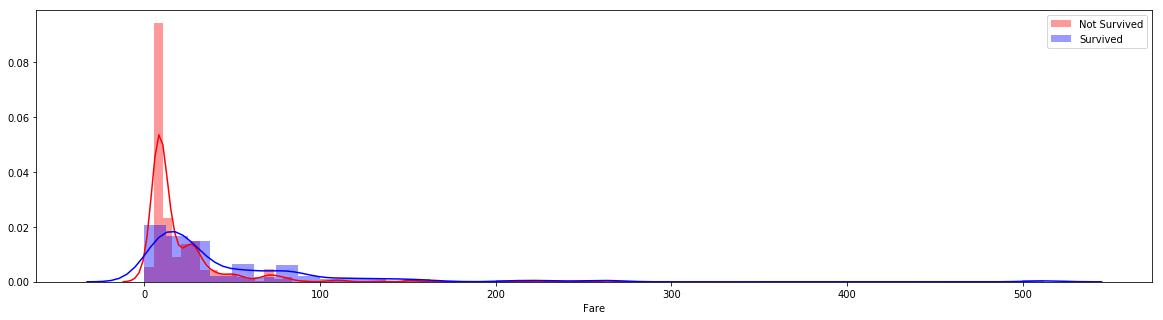

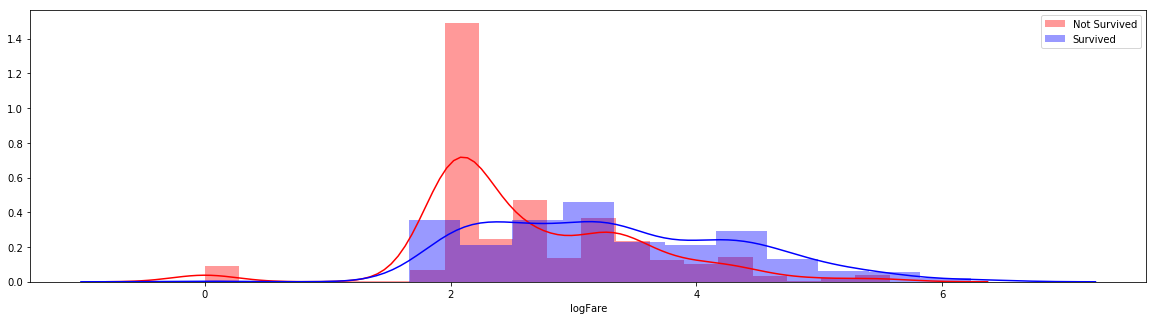

In [8]:
fig, ax = plt.subplots(figsize=(20, 5))
g = sns.distplot(data_c["Fare"][data_c["Survived"] == 0], color="r")
g = sns.distplot(data_c["Fare"][data_c["Survived"] == 1], color="b")
g = g.legend(["Not Survived","Survived"])

for dataset in data_all:
    dataset['logFare'] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
    
fig, ax = plt.subplots(figsize=(20, 5))
g = sns.distplot(data_c["logFare"][data_c["Survived"] == 0], color="r")
g = sns.distplot(data_c["logFare"][data_c["Survived"] == 1], color="b")
g = g.legend(["Not Survived","Survived"])

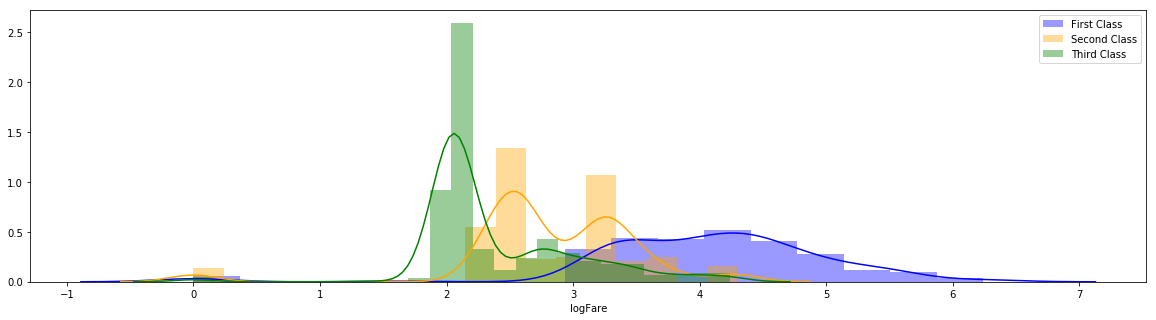

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))
g = sns.distplot(data_c["logFare"][data_c["Pclass"] == 1], color="b")
g = sns.distplot(data_c["logFare"][data_c["Pclass"] == 2], color="orange")
g = sns.distplot(data_c["logFare"][data_c["Pclass"] == 3], color="g")
g = g.legend(["First Class","Second Class","Third Class"])

As we can see above, using a log scale for the Fare lets us visualize better how increased Fare prices lead to increased survival. This is because, as the second graph shows, people how paid more are probably high class, who we presume had an advantage on lower class people. We'll see in a bit that that's the case.

### Other variables

In [12]:
#Here we fill other NAs and drop useless columns
for dataset in data_all:
    dataset['Embarked'].fillna('S', inplace=True)
    
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)
    
    dataset['Cabin'].fillna('U',inplace=True)
    dataset['Cabin'] = dataset['Cabin'].map(lambda x: x[0])
    
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 'Yes'
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 'No'

    #dataset['FareBin'] = pd.qcut(dataset['Fare'], 5)
    #dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5

## Some useful visuals

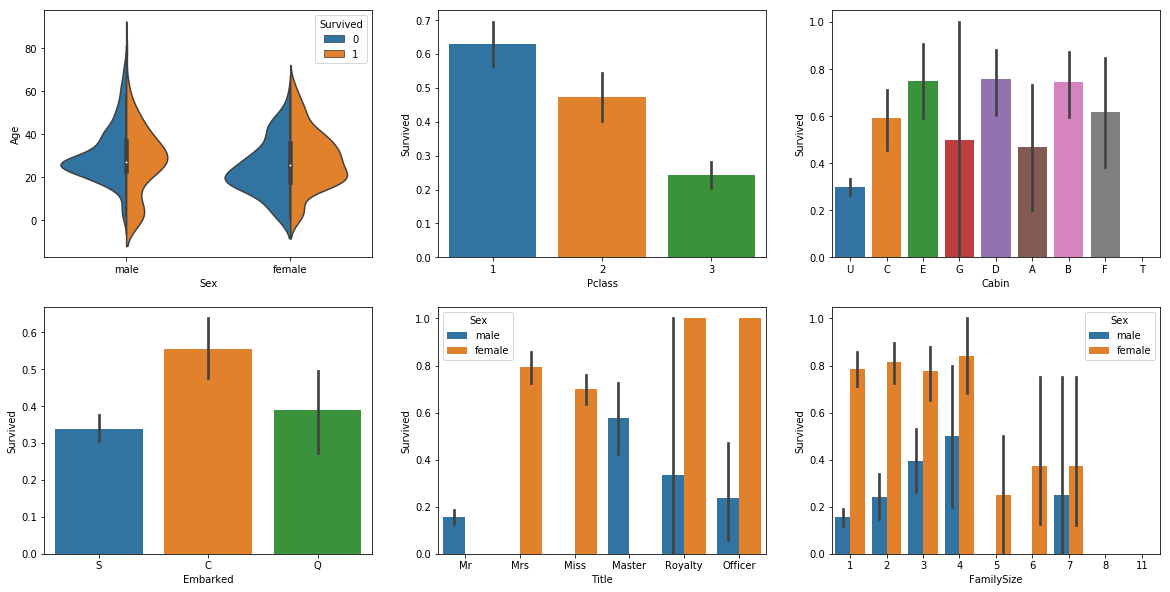

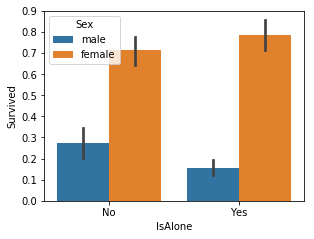

In [21]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
sns.violinplot(x="Sex",y="Age",hue='Survived',data=data_c,split=True,ax=ax[0,0])
sns.barplot(x="Pclass",y="Survived",data=data_c,ax=ax[0,1])
sns.barplot(x="Cabin",y="Survived",data=data_c,ax=ax[0,2])
sns.barplot(x="Embarked",y="Survived",data=data_c,ax=ax[1,0])
sns.barplot(x="Title",y="Survived",hue="Sex",data=data_c,ax=ax[1,1])
sns.barplot(x="FamilySize",y="Survived",hue="Sex",data=data_c,ax=ax[1,2])
fig, ax = plt.subplots(figsize=(4.65,3.5))
sns.barplot(x="IsAlone",y="Survived",hue='Sex',data=data_c)

From this, we can see some characteristics we already presumed:
- Men have lower chances of survival then women, in general (Misters, male officers and male royalty all die far more often). Young men (20-40) are all more likely to die, while women in the same range have far better chances of survival.
- Except for when they're young boys, as we can see the difference in the first chart, and also that the Master title (reserved for young boys) survives much more than any other male title.
- We confirm that the higher the social status (Pclass), the higher the chances for survival. When combining this with sex, we can see that female royalty and female officers have the biggest survival chances. Male royalty also seem to have more chances than Misters, but the uncertainty is too big to draw this conclusion (as seen in the barplot).
- The cabin doesn't seem to impact as much, except for when the person didn't have an informed cabin (U). These were much more likely to die.
- Embarked only seems to make a difference when looking at if the person embarked at C or not.
- Finally, men with smaller families tended to die more, while females tend to die less. It escapes me why, but perhaps, for men, the need to protect a family leads to increased survival, and, for the woman, it's because families of size above 4 seem to be maily women, putting more weight to their total death toll.

In [22]:
for dataset in data_all:
    dataset['Sex'] = dataset['Sex'].map({'male' : 1, 'female' : 0, 1:1, 0:0})
    
    dataset['IsAlone'] = dataset['IsAlone'].map({'Yes' : 1, 'No' : 0, 1:1, 0:0})
    
    #dataset['Embarked'] = dataset['Embarked'].map({'S' : 0, 'C' : 1, 'Q' :2})
    
    #dataset['Cabin'] = dataset['Cabin'].map({'U':0,'C':1,'E':2,'G':3,'D':4,'A':5,'B':6,'F':7,'T':8})
    
    #dataset['Title'] = dataset['Title'].map({'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Royalty':4,'Officer':5})
    
    drop_column = ['PassengerId','Name', 'Ticket','Fare']
    dataset.drop(drop_column, axis=1, inplace = True)

In [23]:
def categorize_row(dataset,row_name):
    dummies = pd.get_dummies(dataset[row_name], prefix=row_name)
    dataset = pd.concat([dataset, dummies], axis=1)
    dataset.drop(row_name, axis=1, inplace=True)
    return dataset

data_c = categorize_row(data_c,'Embarked')
data_c = categorize_row(data_c,'Cabin')
data_c = categorize_row(data_c,'Title')

data_val = categorize_row(data_val,'Embarked')
data_val = categorize_row(data_val,'Cabin')
data_val = categorize_row(data_val,'Title')

data_c.drop('Cabin_T', axis=1, inplace = True)

In [30]:
print(data_c.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())
data_c.head()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
logFare          0
FamilySize       0
IsAlone          0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Cabin_A          0
Cabin_B          0
Cabin_C          0
Cabin_D          0
Cabin_E          0
Cabin_F          0
Cabin_G          0
Cabin_U          0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Officer    0
Title_Royalty    0
dtype: int64
----------
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
logFare          0
FamilySize       0
IsAlone          0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Cabin_A          0
Cabin_B          0
Cabin_C          0
Cabin_D          0
Cabin_E          0
Cabin_F          0
Cabin_G          0
Cabin_U          0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Officer    0
Title_Royalty    0
dtype: 

,Survived,Pclass,Sex,Age,SibSp,Parch,logFare,FamilySize,IsAlone,Embarked_C,...,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0,3,1,22.0,1,0,1.981001,2,0,0,...,0,0,0,1,0,0,1,0,0,0
1,1,1,0,38.0,1,0,4.266662,2,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1,3,0,26.0,0,0,2.070022,1,1,0,...,0,0,0,1,0,1,0,0,0,0
3,1,1,0,35.0,1,0,3.972177,2,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,3,1,35.0,0,0,2.085672,1,1,0,...,0,0,0,1,0,0,1,0,0,0


In [31]:
data_val.head()

,Pclass,Sex,Age,SibSp,Parch,logFare,FamilySize,IsAlone,Embarked_C,Embarked_Q,...,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,1,34.5,0,0,2.057860,1,1,0,1,...,0,0,0,1,0,0,1,0,0,0
1,3,0,47.0,1,0,1.945910,2,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,2,1,62.0,0,0,2.270836,1,1,0,1,...,0,0,0,1,0,0,1,0,0,0
3,3,1,27.0,0,0,2.159003,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3,0,22.0,1,1,2.508582,3,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [43]:
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.model_selection import cross_val_score as cv_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier as GBC
from sklearn.mixture import BayesianGaussianMixture as BGMM
from sklearn.model_selection import GridSearchCV as GridS

In [44]:
y = data_c['Survived'].values
X = data_c.drop('Survived',axis=1).values
y.shape,X.shape

((891,), (891, 25))

In [ ]:
RFC_parameter_grid = {'max_depth' : [4, 6, 8, 10],
                 'n_estimators': [100, 50],
                 'max_features' : ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],}

RFC_grid = GridS(RFC(),
                    scoring='accuracy',
                    param_grid=RFC_parameter_grid,
                    cv=SKF(n_splits=5),
                    verbose=1)

RFC_grid.fit(X, y)

RFC_params = RFC_grid.best_params_

print('Best score: {}'.format(RFC_grid.best_score_))
print('Best parameters: {}'.format(RFC_params))

RFC_model = RFC(**RFC_params)
RFC_model.fit(X,y)

pred = RFC_grid.predict(data_val.values).astype(int)
output = pd.DataFrame()
output['PassengerId'] = test_ids.values
output['Survived'] = pred
output[['PassengerId','Survived']].to_csv('./RFC_prediction.csv', index=False)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [38]:
BGMM_parameter_grid = {,}

BGMM_grid = GridS(BGMM(),
                    scoring='accuracy',
                    param_grid=BGMM_parameter_grid,
                    cv=SKF(n_splits=5),
                    verbose=1)

BGMM_grid.fit(X, y)

BGMM_params = BGMM_grid.best_params_

print('Best score: {}'.format(BGMM_grid.best_score_))
print('Best parameters: {}'.format(BGMM_params))

BGMM_model = BGMM(**BGMM_params)
BGMM_model.fit(X,y)

pred = BGMM_grid.predict(data_val.values).astype(int)
output = pd.DataFrame()
output['PassengerId'] = test_ids.values
output['Survived'] = pred
output[['PassengerId','Survived']].to_csv('./GMM_prediction.csv', index=False)

SyntaxError: invalid syntax (<ipython-input-38-5912e70b314b>, line 1)